<a href="https://colab.research.google.com/github/utkarshx27/Customer-Churn-Analysis-With-PySpark/blob/main/Model_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning with PySpark: Customer Churn Analysis**


### **Loading our data**

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=6a739cb1c11f9d3a5807436ca895a5815b24ab9cbe3fb1d56452f3672717bc52
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


Importing Modules

In [2]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules
import matplotlib.pyplot as plt
import plotly.express as px

# pandas module
import pandas as pd

# pyspark SQL functions
from pyspark.sql.functions import col, when, count, udf

# pyspark data preprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


Building our Spark Session

In [4]:
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

Loading our data

In [5]:
data = spark.read.format('csv').option("header", True).option("inferSchema", True).load("dataset.csv")
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

Print the data schema to check out the data types

In [6]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Get the data dimension

In [7]:
data.count()

7043

### **Exploratory Data Analysis**
- Distribution Analysis
- Correlation Analysis
- Univariate Analysis
- Finding Missing values

In [8]:
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [9]:
data.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'string'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

In [10]:
numerical_columns = [name for name, typ in data.dtypes if typ == "double" or typ == "int"]
categorical_columns = [name for name, typ in data.dtypes if typ == "string"]
data.select(numerical_columns).show()

+------+--------------+------------+
|tenure|MonthlyCharges|TotalCharges|
+------+--------------+------------+
|     1|         29.85|       29.85|
|    34|         56.95|      1889.5|
|     2|         53.85|      108.15|
|    45|          42.3|     1840.75|
|     2|          70.7|      151.65|
|     8|         99.65|       820.5|
|    22|          89.1|      1949.4|
|    10|         29.75|       301.9|
|    28|         104.8|     3046.05|
|    62|         56.15|     3487.95|
|    13|         49.95|      587.45|
|    16|         18.95|       326.8|
|    58|        100.35|      5681.1|
|    49|         103.7|      5036.3|
|    25|         105.5|     2686.05|
|    69|        113.25|     7895.15|
|    52|         20.65|     1022.95|
|    71|         106.7|     7382.25|
|    10|          55.2|      528.35|
|    21|         90.05|      1862.9|
+------+--------------+------------+
only showing top 20 rows



In [11]:
df = data.select(numerical_columns).toPandas()

<ipython-input-12-95b079a8e8f0>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax =ax, bins=20)


array([[<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'MonthlyCharges'}>],
       [<Axes: title={'center': 'TotalCharges'}>, <Axes: >]], dtype=object)

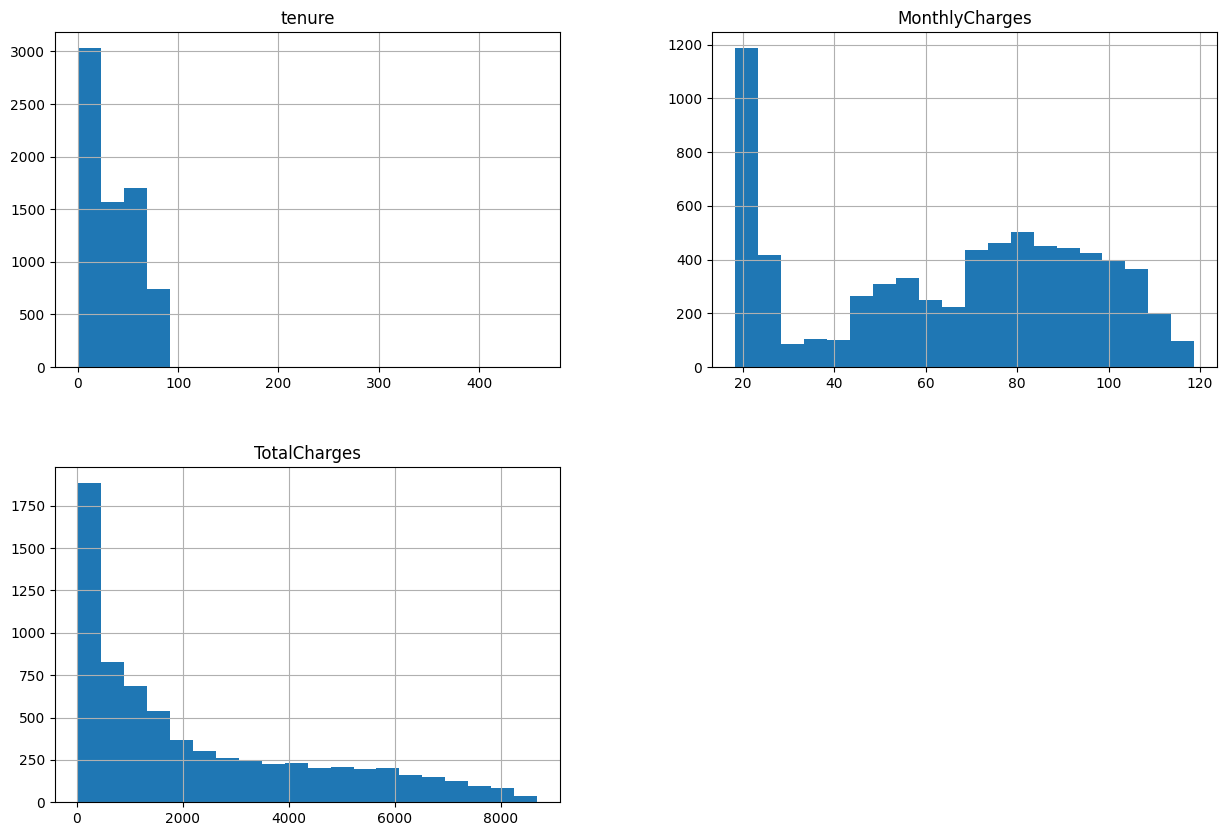

In [12]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()
df.hist(ax =ax, bins=20)

In [13]:
df.tenure.describe()

count    7043.000000
mean       32.435752
std        25.075228
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max       458.000000
Name: tenure, dtype: float64

In [14]:
df.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.243703,0.806530
MonthlyCharges,0.243703,1.000000,0.651065
TotalCharges,0.806530,0.651065,1.000000


In [15]:
categorical_columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [16]:
for column in categorical_columns:
  data.groupBy(column).count().show()

+----------+-----+
|customerID|count|
+----------+-----+
|3668-QPYBK|    1|
|6234-RAAPL|    1|
|1894-IGFSG|    1|
|6982-SSHFK|    1|
|5859-HZYLF|    1|
|6479-OAUSD|    1|
|2592-YKDIF|    1|
|6718-BDGHG|    1|
|3195-TQDZX|    1|
|4248-QPAVC|    1|
|5668-MEISB|    1|
|5802-ADBRC|    1|
|2712-SYWAY|    1|
|2011-TRQYE|    1|
|7244-KXYZN|    1|
|0953-LGOVU|    1|
|3623-FQBOX|    1|
|3692-JHONH|    1|
|3528-HFRIQ|    1|
|7661-CPURM|    1|
+----------+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|           No| 5901|
|          Yes| 1142|
+-------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682

In [17]:
for column in data.columns:
  data.select(count(when(col(column).isNull(),column)).alias(column)).show()

+----------+
|customerID|
+----------+
|         0|
+----------+

+------+
|gender|
+------+
|     0|
+------+

+-------------+
|SeniorCitizen|
+-------------+
|            0|
+-------------+

+-------+
|Partner|
+-------+
|      0|
+-------+

+----------+
|Dependents|
+----------+
|         0|
+----------+

+------+
|tenure|
+------+
|     0|
+------+

+------------+
|PhoneService|
+------------+
|           0|
+------------+

+-------------+
|MultipleLines|
+-------------+
|            0|
+-------------+

+---------------+
|InternetService|
+---------------+
|              0|
+---------------+

+--------------+
|OnlineSecurity|
+--------------+
|             0|
+--------------+

+------------+
|OnlineBackup|
+------------+
|           0|
+------------+

+----------------+
|DeviceProtection|
+----------------+
|               0|
+----------------+

+-----------+
|TechSupport|
+-----------+
|          0|
+-----------+

+-----------+
|StreamingTV|
+-----------+
|          0|
+----------

### **Data Preprocessing**
- Handling the missing values
- Removing the outliers

**Handling the missing values**

In [18]:
columns_with_missing_values = ["TotalCharges"]

In [19]:
imputer = Imputer(inputCols= columns_with_missing_values, outputCols = columns_with_missing_values).setStrategy("mean")

In [20]:
imputer = imputer.fit(data)
data = imputer.transform(data)

In [21]:
data.select(count(when(col("TotalCharges").isNull(),"TotalCharges")).alias("TotalCharges")).show()

+------------+
|TotalCharges|
+------------+
|           0|
+------------+



**Removing the outliers** <br>
find the customer with the tenure higher than 100

In [22]:
data.select("*").where(data.tenure > 100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

In [23]:
data = data.filter(data.tenure < 100)

### **Feature Preparation**
- Numerical Features
    - Vector Assembling
    - Numerical Scaling
- Categorical Features
    - String Indexing
    - Vector Assembling

- Combining the numerical and categorical feature vectors




**Feature Preparation - Numerical Features** <br>

`Vector Assembling --> Standard Scaling` <br>

**Vector Assembling** <br>


In [24]:
numerical_vector_assembler = VectorAssembler(inputCols= numerical_columns, outputCol ="numerical_feature_vector")
data = numerical_vector_assembler.transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_feature_vector|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+------------

**Numerical Scaling** <br>
Let's standardize all of our numerical features.

In [25]:
scaler = StandardScaler(inputCol="numerical_feature_vector",
                        outputCol="numerical_feature_scaled", withStd= True, withMean=True)
data = scaler.fit(data).transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+------------------------+------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_feature_vector|numerical_feature_scaled|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-----------------

**Feature Preperation - Categorical Features** <br>

`String Indexing --> Vector Assembling` <br>

**String Indexing** <br>
We need to convert all the string columns to numeric columns.

In [26]:
categorical_columns_indexed = [name + "_indexed" for name in categorical_columns]
indexer = StringIndexer(inputCols = categorical_columns, outputCols= categorical_columns_indexed)
data = indexer.fit(data).transform(data)

In [27]:
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+------------------------+------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       Paym

Let's combine all of our categorifal features in to one feature vector.

In [28]:
categorical_columns_indexed.remove("customerID_indexed")
categorical_columns_indexed.remove("Churn_indexed")

In [29]:
categorical_vector_assmebler = VectorAssembler(inputCols = categorical_columns_indexed, outputCol="categorical_features_vector")
data = categorical_vector_assmebler.transform(data)

data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+------------------------+------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+---------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|

In [30]:
final_vector_assembler = VectorAssembler(inputCols=["categorical_features_vector", "numerical_feature_scaled"], outputCol= "final_feature_vector")
data = final_vector_assembler.transform(data)

In [31]:
data.select(["final_feature_vector", "Churn_indexed"]).show()

+--------------------+-------------+
|final_feature_vector|Churn_indexed|
+--------------------+-------------+
|(19,[0,2,4,5,6,8,...|          0.0|
|(19,[6,7,9,13,14,...|          0.0|
|(19,[6,7,8,15,16,...|          1.0|
|[0.0,0.0,0.0,0.0,...|          0.0|
|(19,[0,16,17,18],...|          1.0|
|(19,[0,5,9,11,12,...|          1.0|
|(19,[3,5,8,11,15,...|          0.0|
|(19,[0,4,5,6,7,14...|          0.0|
|(19,[0,2,5,9,10,1...|          1.0|
|(19,[3,6,7,8,13,1...|          0.0|
|(19,[2,3,6,7,15,1...|          0.0|
|[0.0,0.0,0.0,0.0,...|          0.0|
|(19,[2,5,9,11,12,...|          0.0|
|(19,[5,8,9,11,12,...|          1.0|
|(19,[7,9,10,11,12...|          0.0|
|[1.0,0.0,1.0,1.0,...|          0.0|
|[1.0,0.0,0.0,0.0,...|          0.0|
|[0.0,0.0,0.0,1.0,...|          0.0|
|(19,[0,2,3,6,9,10...|          1.0|
|(19,[0,8,9,12,16,...|          0.0|
+--------------------+-------------+
only showing top 20 rows



### **Model Training**
- Train and Test data splitting
- Creating our model
- Training our model
- Make initial predictions using our model


In [32]:
train, test = data.randomSplit([0.7, 0.3], seed = 100)
train.count()

4930

In [33]:
dt = DecisionTreeClassifier(featuresCol= "final_feature_vector", labelCol = "Churn_indexed", maxDepth = 6)
model = dt.fit(train)

In [34]:
prediction_test = model.transform(test)
prediction_test.select(["Churn", "prediction"]).show()

+-----+----------+
|Churn|prediction|
+-----+----------+
|  Yes|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       1.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
+-----+----------+
only showing top 20 rows



### **Model Evaluation**
- Calculating area under the ROC curve for the `test` set
- Calculating area under the ROC curve for the `training` set
- Hyper parameter tuning

In [35]:
evaluator = BinaryClassificationEvaluator(labelCol='Churn_indexed')
auc_test = evaluator.evaluate(prediction_test, {evaluator.metricName: "areaUnderROC"})
auc_test

0.7968240892739675

In [36]:
prediction_train = model.transform(train)
auc_train = evaluator.evaluate(prediction_train, {evaluator.metricName: "areaUnderROC"})
auc_train

0.797607974377661

**Hyper parameter tuning**

In [37]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'final_feature_vector', labelCol = 'Churn_indexed', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_indexed")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_indexed")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)

In [38]:
maxDepths = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
test_accs, train_accs = evaluate_dt(maxDepths)
print(train_accs)
print(test_accs)

[0.7737711024910238, 0.7721112330375414, 0.6732017750857608, 0.5647403286677019, 0.797607974377661, 0.7600331160893413, 0.7616399322585649, 0.7851198149534798, 0.82591977092655, 0.8633625692715379, 0.8899907318309699, 0.9236516335825413, 0.9402616892332477, 0.9521037242780167, 0.9662424766482165, 0.9763120733848871, 0.9807472862567603, 0.9853808496196841, 0.9883361989750398]
[0.7918744332963926, 0.7678230877272001, 0.6938514510575503, 0.5664944085244075, 0.7968240892739675, 0.7464077658395512, 0.7486976928866473, 0.7390283218461648, 0.7568262227463716, 0.7717528253693575, 0.770466222983424, 0.7493673661690539, 0.7371905724224987, 0.7208594338001293, 0.7102797812005524, 0.704298946894316, 0.7036452746549405, 0.6956814962753128, 0.6895714683623821]


In [39]:
df = pd.DataFrame()
df["maxDepth"] = maxDepths
df["trainAcc"] = train_accs
df["testAcc"] = test_accs

px.line(df, x = "maxDepth", y = ["trainAcc", "testAcc"])

### **Model Deployment**
- Giving Recommendations using our model



We were asked to recommend a solution to reduce the customer churn.


In [40]:
feature_importance = model.featureImportances
scores = [score for i, score in enumerate(feature_importance)]
df = pd.DataFrame(scores, columns=["score"], index= categorical_columns_indexed + numerical_columns)
px.bar(df, y="score")

In [41]:
df = data.groupby(["Contract", "Churn"]).count().toPandas()
px.bar(df, x="Contract", y="count", color = "Churn")

The bar chart displays the number of churned customers based on their contract type. It is evident that customers with a "Month-to-month" contract have a higher churn rate compared to those with "One year" or "Two year" contracts. As a recommendation, the telecommunication company could consider offering incentives or discounts to encourage customers with month-to-month contracts to switch to longer-term contracts.